In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# The last element contains the labels
labels = raw_data[:, -1]    #all rows of last column

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]   # whole table ka data except last column

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21       #testing ke liye 20% data use hua , random state =21 means 21-21 ke slot mai train krey
)

In [4]:
min_val = tf.reduce_min(train_data)    #minimum value
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)   #normalization   0 to 1  like assignment 2
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)  #converting the data type of calculated value into float.
test_data = tf.cast(test_data, tf.float32)

In [5]:
train_labels = train_labels.astype(bool)     #converting NA value into true
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]     #if label is true then store in normal
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]  #if label is false then store in anamolous
anomalous_test_data = test_data[~test_labels]

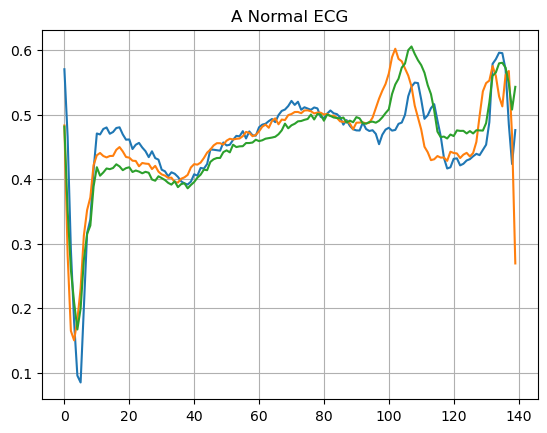

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])       #140 is the number of cols
plt.plot(np.arange(140), normal_train_data[1])
plt.plot(np.arange(140), normal_train_data[2])
plt.title("A Normal ECG")
plt.show()

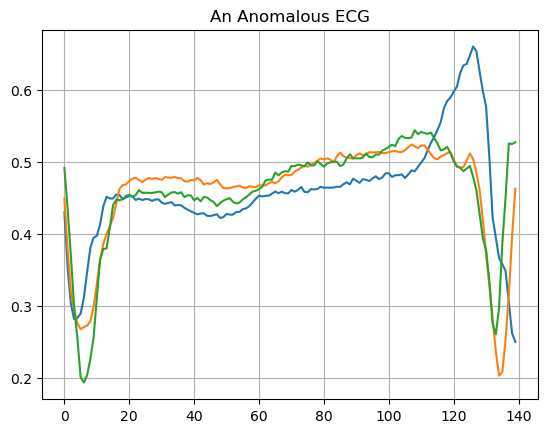

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.plot(np.arange(140), anomalous_train_data[1])
plt.plot(np.arange(140), anomalous_train_data[2])
plt.title("An Anomalous ECG")
plt.show()

In [8]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([     #downsampler or encoder
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])   #it takes a data in higher compression and cob=verts it into lower dimension i.e data compression
                                             #and it reduces its size to vector of 8
                                            
    self.decoder = tf.keras.Sequential([     #upsampler or decoder
      layers.Dense(16, activation="relu"),     #ab yeh lower dimsenion to higher dimension convert krta hai i.e. reconstruction.
      layers.Dense(32, activation="relu"),      #ab iss reconstruction mai loss hota hai    #relu adds non-linearoty
      layers.Dense(140, activation="sigmoid")])     # for outout of reconstrauction       #sigmoid gives probablistic value betn 0 and 1.

  def call(self, x):
    encoded = self.encoder(x)            #x is input data
    decoded = self.decoder(encoded)    # passing encoder to decoder and returning the decoded value.
    return decoded

autoencoder = AnomalyDetector()

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')  
  #loss is calculted using mean absolute error ,  adam is the advanced version og sgd and it gives faster result than sge
  #optimizer is used to control the learning rate and weights , loss should be minimum

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,   #.fit means we are training we need to pass 2 corinates i.e. x and y so 
#and it is unsupervised kearning so first is training and second mai aapan dummy vakue oass krte for y
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")    #

plt.legend()

In [ ]:
#for normal dataa
#to use encoder and decoder separetly
encoded_data = autoencoder.encoder(normal_test_data).numpy()  
decoded_data = autoencoder.decoder(encoded_data).numpy()
encoded_data.shape()    #563,8    8 bcoz vector ka size 8 tha
decoded_data.shape()     #563,140   140 bcoz reconstructed ka sizee 140 tha.

plt.plot(normal_test_data[0], 'b')   #data to be tested
plt.plot(decoded_data[0], 'r')        #output that we got
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')   #better representation of eror
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
# for anamaolous data
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)          #passing normal data to autoencoder instaead of passing to enoder and decoder to predict
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)   #finding the loss/differnve between reconsyructed data and normal data using mae  

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):    #predecting ki normal ya anamlous  hai  if fyction ka outut is true that means ecg data is normal and false means it is anamolous.
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)